In [1]:
# https://github.com/ray-project/ray/blob/master/rllib/examples/sb2rllib_rllib_example.py
import gymnasium as gym
import ray
from ray import tune, air
import ray.rllib.algorithms.ppo as ppo

In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init(num_gpus=1, local_mode=False)

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2023-01-07 21:09:15,850	INFO worker.py:1536 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.15
Ray version:,3.0.0.dev0
Dashboard:,http://127.0.0.1:8265


In [3]:
# settings used for both stable baselines and rllib
import platoonenv
env_name = "Platoon-v2"
train_steps = 10000
learning_rate = 1e-3
save_dir = "saved_models"

In [4]:
env = gym.make(env_name)
print("reward_threshold", env.spec.reward_threshold)
print("max_episode_steps", env.spec.max_episode_steps)

reward_threshold 0
max_episode_steps 20


In [5]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig

config = (
    PPOConfig()
    .environment(env_name)
    .framework("torch")
    .rollouts(num_rollout_workers=10)
    .resources(num_gpus=1)
)
algo = config.build()

(RolloutWorker pid=19992) 2023-01-07 21:09:31,640	INFO policy.py:1196 -- Policy (worker=5) running on CPU.
(RolloutWorker pid=19992) 2023-01-07 21:09:31,640	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=22272) 2023-01-07 21:09:31,629	INFO policy.py:1196 -- Policy (worker=6) running on CPU.
(RolloutWorker pid=22272) 2023-01-07 21:09:31,629	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=24324) 2023-01-07 21:09:31,700	INFO policy.py:1196 -- Policy (worker=8) running on CPU.
(RolloutWorker pid=24324) 2023-01-07 21:09:31,700	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=22820) 2023-01-07 21:09:31,742	INFO policy.py:1196 -- Policy (worker=2) running on CPU.
(RolloutWorker pid=22820) 2023-01-07 21:09:31,742	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
(RolloutWorker pid=1348) 2023-01-07 21:09:31,804	INFO policy.py:1196 -- Policy (worker=9) running on CPU.
(RolloutWorker pid=134

In [6]:
from IPython.display import clear_output
def plot(rewards_history):
    clear_output(True)
    plt.figure(figsize=(12, 5))
    plt.title("Training...")
    plt.xlabel("Step")
    plt.ylabel("Rewards")
    plt.plot([x["episode_reward_mean"] for x in rewards_history])
    plt.show()

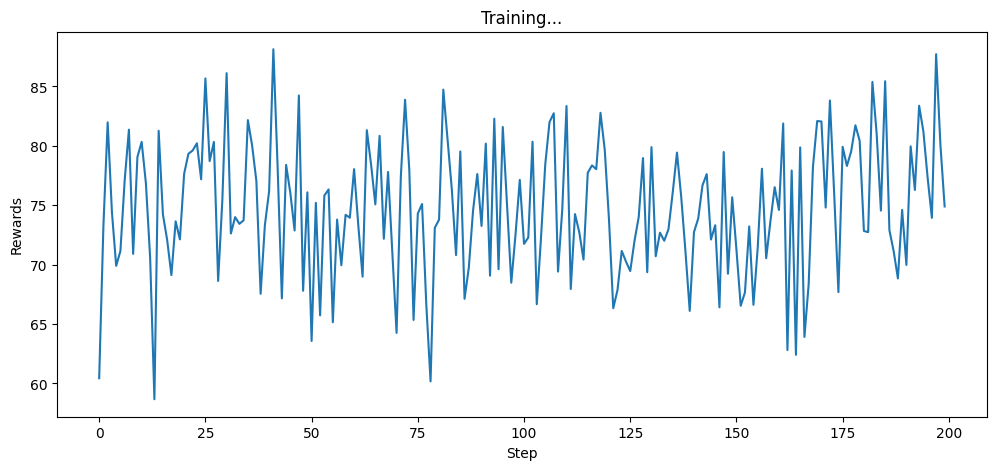

74.8975: 100%|██████████| 200/200 [39:49<00:00, 11.95s/it]


In [8]:
from tqdm import tqdm
import matplotlib.pyplot as plt
train_steps = 200
results_history = []
plot_every = 1
with tqdm(total=train_steps) as pbar:
    for i in range(train_steps):
        results = algo.train()
        pbar.set_description(str(results["episode_reward_mean"]))
        results_history.append(results)
        pbar.update()
        if i % plot_every == 0:
            plot(results_history)
            pbar.display()
        

In [9]:
algo.save(save_dir)

'saved_models\\checkpoint_000400'

In [ ]:
# inference
env = gym.make(env_name)
obs, info = env.reset()
for i in range(1000):
    action = algo.compute_single_action(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        print(f"Cart pole ended after {i} steps. {env.spec.reward_threshold}")
        break

Cart pole ended after 217 steps. 475.0


c:\Users\TeamD\.conda\envs\rllib\lib\site-packages\gymnasium\envs\classic_control\cartpole.py:212: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(
